In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

from copy import deepcopy
import logging
import math
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colors
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import r2_score
from sklearn.manifold import Isomap
from spynal.spikes import density
import sys

sys.path.append('../../')
from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from utils import numpy_torch_conversion
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

sys.path.append('/om2/user/eisenaj/code/repos/jPCA')
from jPCA import jPCA

plt.style.use('../../sci_style.py')

# Functions

In [4]:
class PCA:
    def __init__(self, n_components=None, use_torch=False, device='cpu', dtype='torch.DoubleTensor'):
        self.n_components = n_components
        self.use_torch = use_torch
        self.device = device
        self.dtype = dtype
        
    def compute_multidim_mean(self, data):
        return data.mean(axis=tuple(np.arange(0, len(data.shape)-1)))
    
    def fit(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)   
        data_centered = data - self.compute_multidim_mean(data)
        if self.use_torch:
            U, S, Vh = torch.linalg.svd(data_centered, full_matrices=False)
            self.U = U
            self.S = S
            self.V = Vh.T

        else:
            U, S, Vh = np.linalg.svd(data_centered, full_matrices=False)
            self.U = U
            self.S = S
            self.V = Vh.T
        
        self.explained_variance_ = ((S**2)/(data.shape[0] - 1))[:self.n_components]
    
    def transform(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)
        data_centered = data - self.compute_multidim_mean(data)
        return (data_centered) @ self.V[:, :self.n_components]

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
def get_bins(spike_mat, bin_size):
    """
    Helper function for get_up_down_raw() function. 

    Calculate number of bins based on bin_size, remove extra
    data at end, and return spikes/bin count array.
    """
    trial_length = spike_mat.shape[1]
    n_bins = np.floor(trial_length / bin_size)

    cut_ind = int(n_bins*bin_size)

    clipped_spike_mat = spike_mat[:,:cut_ind]
    
    return sum_bins(clipped_spike_mat, n_bins)
    
def sum_bins(spike_mat, n_bins):
    """
    Helper function for get_bins() function. 

    Break apart spike_mat (0/1 spike array) into n_bins and
    return (n_bin,) length array containing spike counts per bin.
    """
    split = np.hsplit(spike_mat, n_bins)
    join = np.stack(split)
    
    return join.sum(axis=(1,2))

def get_up_down_raw(area_spike_dict, bin_size=200, Fs=1000, thresh=0.1, 
                trange=None, smooth=True):
    """
    For each spike array in area_spike_dict, get 0/1 Up/Down array at bin_size 
    resolution.
    Optional smooth: fill in 101 case with 111
    Returns dictionary with Up/Down raw array per region.
    """
    
    areas = list(area_spike_dict.keys())

    data_length = area_spike_dict[areas[0]].shape[1]
    # n_bins = int(np.floor(data_length / bin_size))
    
    if trange is None:
        trange = np.arange(data_length)
    
    binned_up_down_dict = {}
    
    for a, spikes in area_spike_dict.items():
        if a == '7b':
            thresh = 0.2
        else:
            thresh = thresh

        binned = get_bins(spikes, bin_size)
        binned_up_down_dict[a] = (((binned / area_spike_dict[a].shape[0])\
                        * (200/bin_size)) > thresh).astype(float)

    if smooth:
        for a, binned in binned_up_down_dict.items():
            for n in range(binned.size):
                if n == 0 or n == binned.size-1:
                    pass
                else:
                    if binned[n-1] == 1 and binned[n+1] == 1:
                        binned[n] = 1

    up_down_dict = {k: np.repeat(v, bin_size) for k,v\
                    in binned_up_down_dict.items()}
    
    return up_down_dict

# NOTE - some shoddy conditionals for handling boundary issues
# WATCH FOR ISSUES
def get_up_edges(up_down_array):
    """
    Get indices for starts/ends of sequence of ones in up_down_array.
    Check / fix common errors due to boundary issues.
    """
    starts = np.where(np.diff(up_down_array) == 1)[0] + 1
    ends = np.where(np.diff(up_down_array) == -1)[0] + 1
    
    if ends[0] <= starts[0]:
        ends = ends[1:]
        starts = starts[:-1]
        
    if ends.size != starts.size:
        min_size = min(ends.size, starts.size)
        starts = starts[:min_size]
        ends = ends[:min_size]
    
    return starts, ends



def trim_up_down_array(expanded_up, area_spike_seg):
    """
    Remove trailing Up/Down labels based on 0-spike counts at 
    beginning/end of Up segement in Up/Down array.
    """
    trimmed_up = np.zeros(expanded_up.size)
    up_starts, up_ends = get_up_edges(expanded_up)
    # need to handle case where these aren't equal?
    for i in range(up_starts.size):
        s = up_starts[i]
        e = up_ends[i]
        up_seg = area_spike_seg[:,s:e]
        
        nonzeros = np.nonzero(up_seg.sum(0))[0]
        new_s = s + nonzeros[0]
        new_e = s + nonzeros[-1]
        
        trimmed_up[new_s:new_e] = 1
        
    return trimmed_up

def trim_up_down(expand_dict, area_spikes_dict):
    """
    Apply trim_up_down_array to each region in dictionary.
    """
    trimmed_dict = {}
    for a in expand_dict.keys():
        expand_up = expand_dict[a]
        spikes_seg = area_spikes_dict[a]
        
        trimmed_dict[a] = trim_up_down_array(expand_up, spikes_seg)
        
    return trimmed_dict

def get_up_down(area_spike_dict, bin_size=200):
    """
    Apply full Up/Down processing to each region in area_spike_dict.
    Returns new dictionary w/ full/processed Up/Down array per region.
    """
    raw_up_down_dict = get_up_down_raw(area_spike_dict, bin_size=bin_size)
    up_down_dict = trim_up_down(raw_up_down_dict, area_spike_dict)

    return up_down_dict

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Load Data

In [4]:
session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [1]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

NameError: name 'get_data_class' is not defined

In [6]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [7]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [8]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

In [14]:
# area_spike_dict = {}
# for area in np.hstack([session_info['areas']]):
#     print(area)
#     if area == 'all':
#         unit_inds = np.arange(len(unit_info['area']))
#     else:
#         unit_inds = np.where(unit_info['area'] == area)[0]
#     area_spike_dict[area] = np.zeros((len(unit_inds), T))
#     for i, ind in enumerate(unit_inds):
#         unit_spike_times = spike_times[ind]
#         for t in unit_spike_times:
#             area_spike_dict[area][i, int(t/dt)] = 1
# up_down_dict = get_up_down(area_spike_dict, bin_size=200)

# Analyze!

In [15]:
width = 0.1 # s
# step = 0.1 # s
step = width*2 # s
# kernel='hanning'
kernel = 'gaussian'
dt_rate = step

area = 'vlPFC'

if area == 'all':
    electrode_indices = np.arange(len(electrode_info['area']))
else:
    electrode_indices = np.where(electrode_info['area'] == area)[0]

if area == 'all':
    unit_indices = np.arange(len(unit_info['area']))
else:
    unit_indices = np.where(unit_info['area'] == area)[0]

In [16]:
rates = None
for i in tqdm(range(len(unit_indices))):
    unit_rates, _ = density(spike_times[i], lims=[0, (lfp.shape[0] - 1)*dt], kernel=kernel, width=width, step=step)
    if rates is None:
        rates = np.zeros((len(unit_rates), len(unit_indices)))
    rates[:, i] = unit_rates

  0%|          | 0/82 [00:00<?, ?it/s]

In [17]:
start_wake = 100 # s
start_anesthesia = session_info['drugStart'][1] # s
# window = 15 # s
# window_lfp = int(window/dt)
# window_rate = int(window/dt_rate)
window_lfp = 15000
window_rate = 15000
# T_pred = 5 # s
# T_pred_lfp = int(T_pred/dt)
# T_pred_rate = int(T_pred/dt_rate)
T_pred_lfp = 5000
T_pred_rate = 5000

signal_wake_rate = np.copy(rates[int(start_wake/dt_rate):int(start_wake/dt_rate) + window_rate, unit_indices])
signal_wake_rate -= signal_wake_rate.mean(axis=0)
signal_anesthesia_rate = np.copy(rates[int(start_anesthesia/dt_rate):int(start_anesthesia/dt_rate) + window_rate, unit_indices])
signal_anesthesia_rate -= signal_anesthesia_rate.mean(axis=0)

signal_wake_rate_test = np.copy(rates[int(start_wake/dt_rate) + window_rate:int(start_wake/dt_rate) + window_rate + T_pred_rate, unit_indices])
signal_wake_rate_test -= signal_wake_rate_test.mean(axis=0)
signal_anesthesia_rate_test = np.copy(rates[int(start_anesthesia/dt_rate) + window_rate:int(start_anesthesia/dt_rate) + window_rate + T_pred_rate, unit_indices])
signal_anesthesia_rate_test -= signal_anesthesia_rate_test.mean(axis=0)

signal_wake_lfp = np.copy(lfp[int(start_wake/dt):int(start_wake/dt) + window_lfp, electrode_indices])
signal_wake_lfp -= signal_wake_lfp.mean(axis=0)
signal_anesthesia_lfp = np.copy(lfp[int(start_anesthesia/dt):int(start_anesthesia/dt) + window_lfp, electrode_indices])
signal_anesthesia_lfp -= signal_anesthesia_lfp.mean(axis=0)

In [18]:
# matrix_size = 6000
# r = 4500

matrix_size = 1000
r = 1000

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
%%time
delase_w_rate = DeLASE(signal_wake_rate + np.random.randn(*signal_wake_rate.shape)*0.0001, dt=dt_rate, matrix_size=matrix_size, use_torch=True, device=device)
# delase_w_lfp = DeLASE(signal_wake_lfp, dt=dt, matrix_size=matrix_size, use_torch=True, device=device)

delase_a_rate = DeLASE(signal_anesthesia_rate + np.random.randn(*signal_anesthesia_rate.shape)*0.001, dt=dt_rate, matrix_size=matrix_size, use_torch=True, device=device)
# delase_a_lfp = DeLASE(signal_anesthesia_lfp, dt=dt, matrix_size=matrix_size, use_torch=True, device=device)

CPU times: user 6.87 s, sys: 3.03 s, total: 9.89 s
Wall time: 10.2 s


In [22]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
# num_vals = 4500
# ax = axs[0]
# ax.plot(delase_w_rate.cumulative_explained_variance.cpu()[:num_vals], label=f'Firing Rates')
# ax.plot(delase_w_lfp.cumulative_explained_variance.cpu()[:num_vals], label=f'LFPs')
# ax.legend()
# ax.set_xlabel('Singular Value #')
# ax.set_ylabel('Cumulative Explained Variance %', fontsize=16)
# ax.set_title('Wake')

# ax = axs[1]
# ax.plot(delase_a_rate.cumulative_explained_variance.cpu()[:num_vals], label=f'Firing Rates')
# ax.plot(delase_a_lfp.cumulative_explained_variance.cpu()[:num_vals], label=f'LFPs')
# ax.legend()
# ax.set_xlabel('Singular Value #')
# # ax.set_ylabel('Cumulative Explained Variance %')
# ax.set_title('Anesthesia')

# plt.suptitle(f'Explained Variance From {area} Signals, Window LFP = {window_lfp*dt}, Window Rate = {window_rate*dt_rate}, Matrix Size = {matrix_size}')
# plt.tight_layout()
# plt.show()

In [24]:
delase_w_rate.compute_havok_dmd(r=r)
# delase_w_lfp.compute_havok_dmd(r=r)
delase_a_rate.compute_havok_dmd(r=r)
# delase_a_lfp.compute_havok_dmd(r=r)

In [25]:
preds_w = delase_w_rate.predict_havok_dmd(signal_wake_rate, tail_bite=True, reseed=1)
preds_a = delase_a_rate.predict_havok_dmd(signal_anesthesia_rate, tail_bite=True, reseed=1)

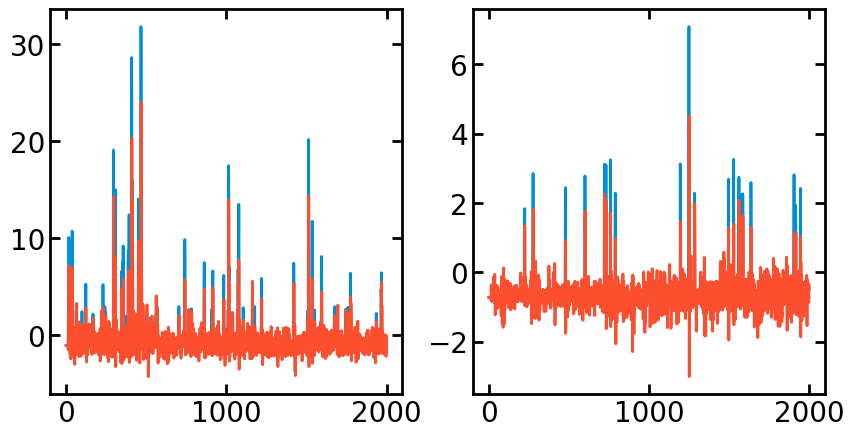

In [26]:
plt.subplot(1, 2, 1)
plt.plot(signal_wake_rate[:2000, 4])
plt.plot(preds_w.cpu()[:2000, 4])

plt.subplot(1, 2, 2)
plt.plot(signal_anesthesia_rate[:2000, 4])
plt.plot(preds_a.cpu()[:2000, 4])
plt.show()

In [ ]:
delase_w_rate.get_stability(max_freq=1/(2*dt_rate), max_unstable_freq=np.min([125, 1/(2*dt_rate)]))
delase_w_lfp.get_stability(max_freq=1/(2*dt), max_unstable_freq=np.min([125, 1/(2*dt)]))
delase_a_rate.get_stability(max_freq=1/(2*dt_rate), max_unstable_freq=np.min([125, 1/(2*dt_rate)]))
delase_a_lfp.get_stability(max_freq=1/(2*dt), max_unstable_freq=np.min([125, 1/(2*dt)]))

In [ ]:
top_percent = 0.2

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(delase_w_lfp.stability_params[:int(top_percent*len(delase_w_rate.stability_params))].cpu(), label='wake')
plt.plot(delase_a_lfp.stability_params[:int(top_percent*len(delase_a_rate.stability_params))].cpu(), label='anesthesia')
plt.title('LFPs')

plt.subplot(1, 2, 2)
plt.plot(delase_w_rate.stability_params[:int(top_percent*len(delase_w_rate.stability_params))].cpu(), label='wake')
plt.plot(delase_a_rate.stability_params[:int(top_percent*len(delase_a_rate.stability_params))].cpu(), label='anesthesia')
plt.title('Rates')

plt.show()

# Parameter Testing

In [27]:
parameter_grid = ParameterGrid(
    window_vals=np.array([15000]),
#     matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000, 3000]),
    matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1250, 1500, 2000, 2500, 3000]),
    r_vals = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2250, 2500]),
    reseed=False
)

In [28]:
all_results = {}
for key, train_signal, test_signal in [('wake', signal_wake_rate, signal_wake_rate_test), ('anesthesia', signal_anesthesia_rate, signal_anesthesia_rate_test)]:
    train_signal += np.random.randn(*train_signal.shape)*0.01
    all_results[key] = parameter_search(train_signal, test_signal, parameter_grid=parameter_grid, dt=dt, use_torch=True, device='cuda', verbose=True)

  0%|          | 0/434 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

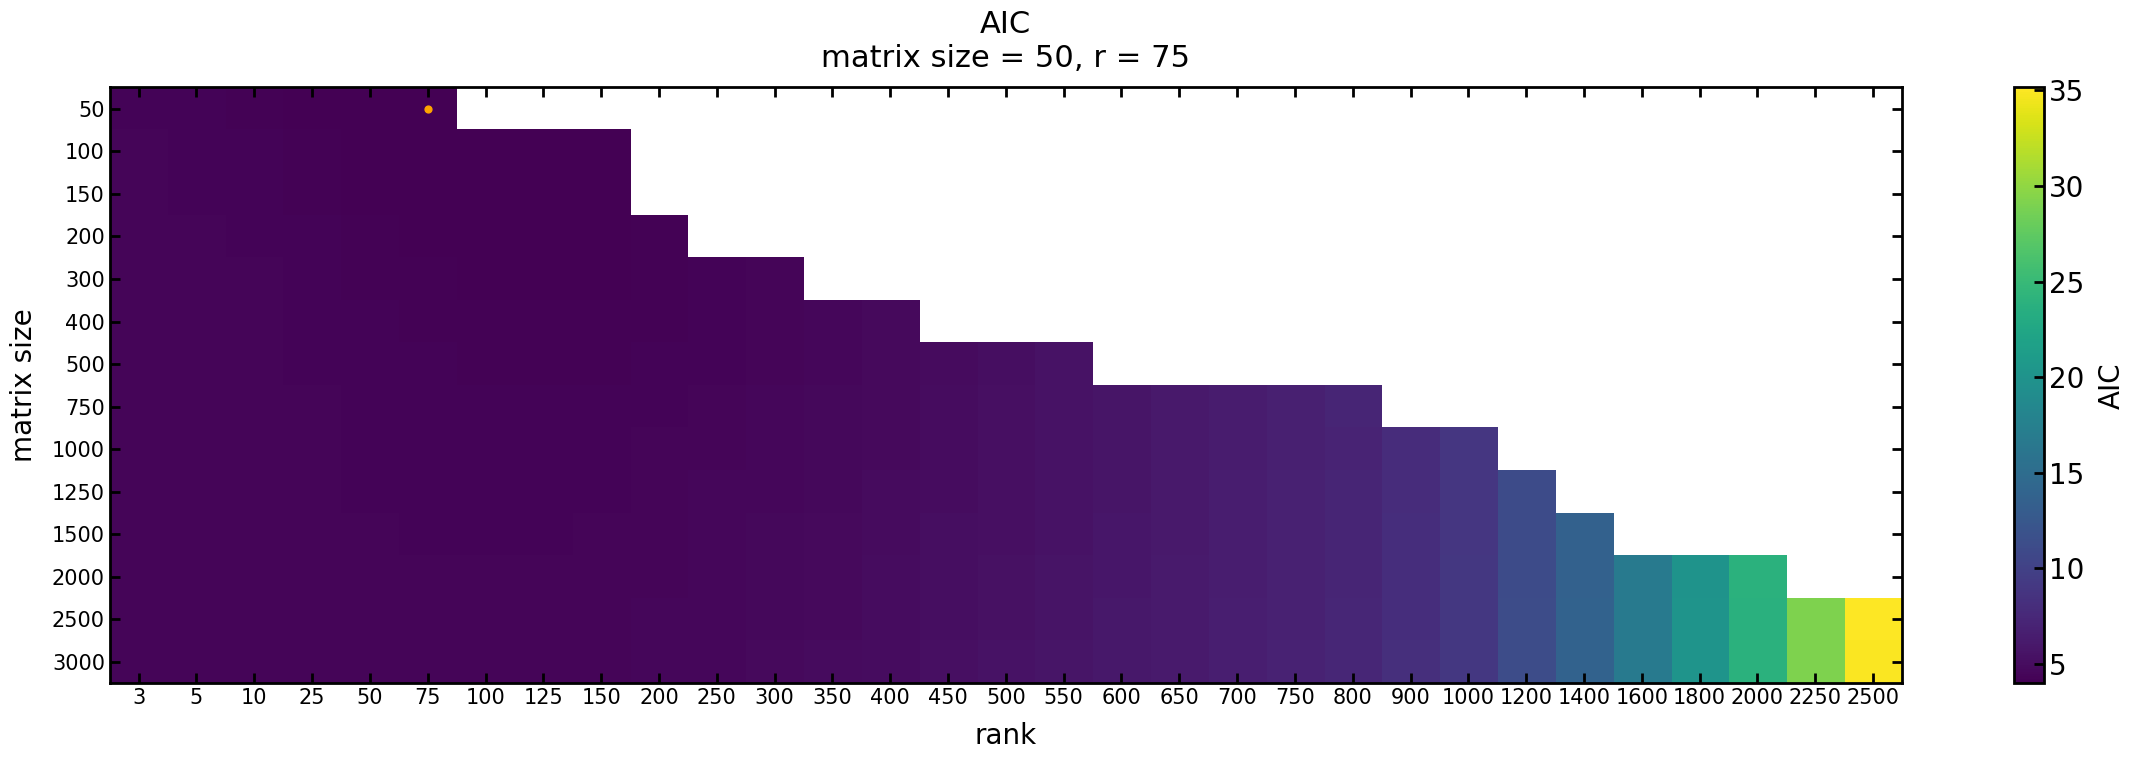

In [29]:
plot_AIC(all_results)

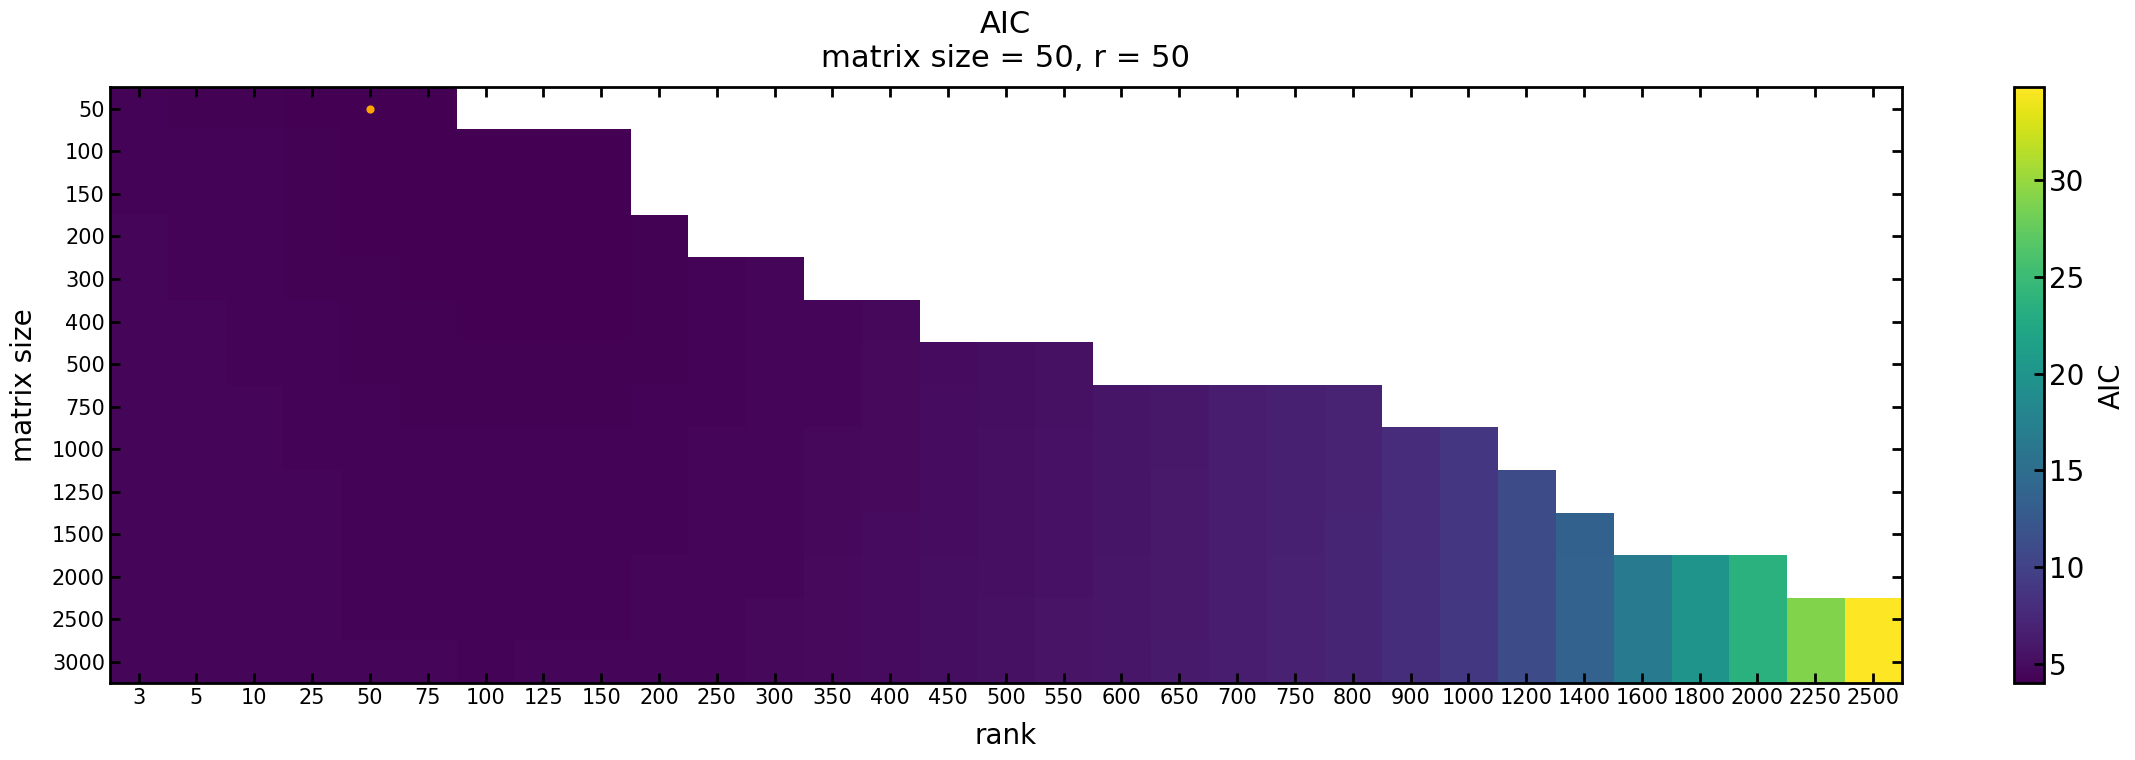

In [30]:
plot_AIC({'wake': all_results['wake']})

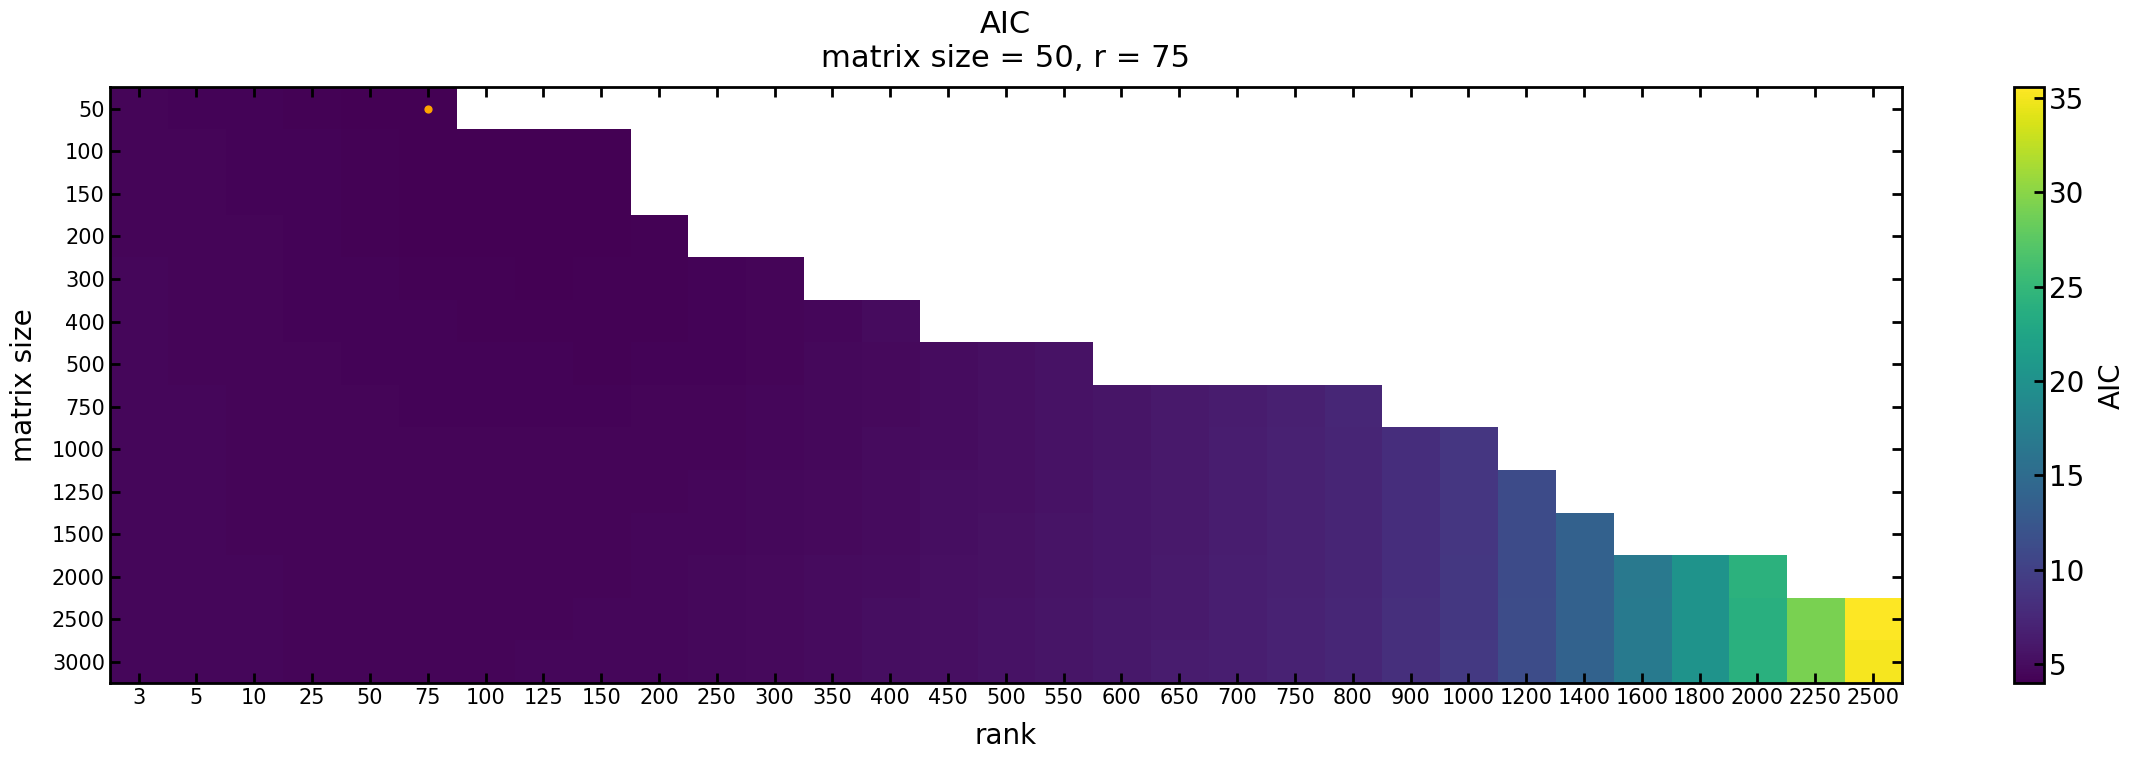

In [31]:
plot_AIC({'anesthesia': all_results['anesthesia']})

In [38]:
window, matrix_size, r, _ = combine_grid_results(all_results)

                                                          stability_params  \
window matrix_size r                                                         
15000  50          3     [-499.9991, -499.9991, -499.9992, -499.9992, -...   
                   5     [-411.20312, -411.20312, -499.99908, -499.9990...   
                   10    [-310.02258, -338.61456, -338.61456, -397.1062...   
                   25    [-252.05853, -301.2859, -301.2859, -376.52838,...   
                   50    [-195.04471, -288.14288, -288.14288, -353.0393...   
...                                                                    ...   
       3000        1600  [-0.9354248, -3.1550856, -7.0969296, -7.096929...   
                   1800  [-0.9149893, -3.3597777, -6.8168373, -6.816837...   
                   2000  [-0.9592169, -3.7479596, -6.8574057, -6.857405...   
                   2250  [-1.037133, -4.3306313, -6.865278, -6.865278, ...   
                   2500  [-1.0818843, -4.538985, -6.865162, -6.8

KeyError: 'time_vals'

In [45]:
matrix_size = 50
r = 75

In [40]:
%%time
delase_w_rate = DeLASE(signal_wake_rate + np.random.randn(*signal_wake_rate.shape)*0.0001, dt=dt_rate, matrix_size=matrix_size, use_torch=True, device=device)
# delase_w_lfp = DeLASE(signal_wake_lfp, dt=dt, matrix_size=matrix_size, use_torch=True, device=device)

delase_a_rate = DeLASE(signal_anesthesia_rate + np.random.randn(*signal_anesthesia_rate.shape)*0.001, dt=dt_rate, matrix_size=matrix_size, use_torch=True, device=device)
# delase_a_lfp = DeLASE(signal_anesthesia_lfp, dt=dt, matrix_size=matrix_size, use_torch=True, device=device)

CPU times: user 204 ms, sys: 34.9 ms, total: 239 ms
Wall time: 231 ms


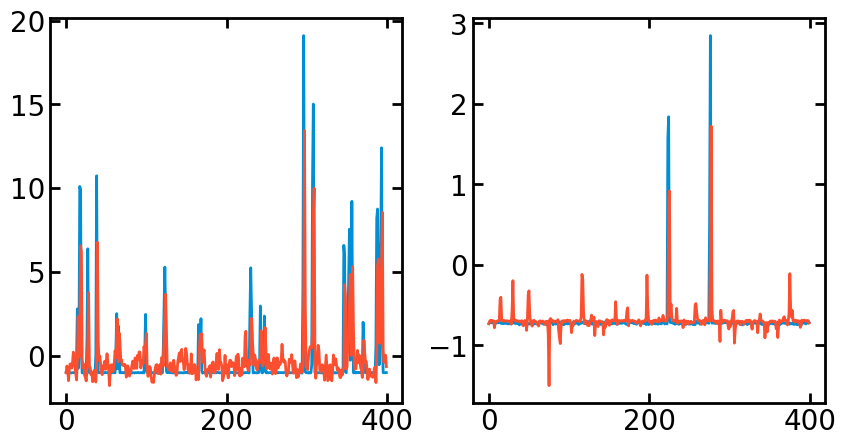

In [43]:
delase_w_rate.compute_havok_dmd(r=r)
# delase_w_lfp.compute_havok_dmd(r=r)
delase_a_rate.compute_havok_dmd(r=r)
# delase_a_lfp.compute_havok_dmd(r=r)

preds_w = delase_w_rate.predict_havok_dmd(signal_wake_rate, tail_bite=True, reseed=1)
preds_a = delase_a_rate.predict_havok_dmd(signal_anesthesia_rate, tail_bite=True, reseed=1)
plt.subplot(1, 2, 1)
plt.plot(signal_wake_rate[:400, 4])
plt.plot(preds_w.cpu()[:400, 4])

plt.subplot(1, 2, 2)
plt.plot(signal_anesthesia_rate[:400, 4])
plt.plot(preds_a.cpu()[:400, 4])
plt.show()

In [50]:
window = 15000

In [51]:
m_index = np.where(parameter_grid.matrix_size_vals == 50)[0]
t_index = np.where(parameter_grid.r_vals == 75)[0]

In [52]:
top_percent = 0.05

In [53]:
picked_color = 'orange'

In [ ]:
title_size = 30
label_size = 15
%matplotlib inline
fig, axs = plt.subplots(len(parameter_grid.matrix_size_vals), len(parameter_grid.r_vals), figsize=(70, 18))
for i, r in enumerate(parameter_grid.r_vals):
    for j, matrix_size in enumerate(parameter_grid.matrix_size_vals):
        ax = axs[j][i]
        
        if (window, matrix_size, r) in all_results['wake'].index:
            wake_stab = all_results['wake'].loc[(window, matrix_size, r)].stability_params
            anesthesia_stab = all_results['anesthesia'].loc[(window, matrix_size, r)].stability_params
            ax.plot(wake_stab[:int(top_percent*len(wake_stab))])
            ax.plot(anesthesia_stab[:int(top_percent*len(anesthesia_stab))])   
                
        if j == 0:
            ax.set_title(f'{r}', fontsize=title_size)
        if i == 0:
            ax.set_ylabel(f'{matrix_size}', fontsize=title_size)
        ax.tick_params(labelsize=label_size)
            
        if j == m_index and i == t_index:
            for spine in ax.spines.values():
                spine.set_color(picked_color)
                spine.set_linewidth(4)
            
                ax.spines['bottom'].set_color(picked_color)
                ax.spines['top'].set_color(picked_color) 
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_color(picked_color)

#                 ax2.spines['bottom'].set_color(picked_color)
#                 ax2.spines['top'].set_color(picked_color) 
#                 ax2.spines['right'].set_color(picked_color)
#                 ax2.spines['left'].set_visible(False)
            
        
plt.suptitle(f'{session}, {area} - Top {top_percent*100}% of Stability Indices with Window {parameter_grid.window_vals[0]}', fontsize=36)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Dimensionality Reduction

In [31]:
width = 0.1 # s
step = 0.001 # s
dt_rate = step

area = 'CPB'
if area == 'all':
    unit_indices = np.arange(len(unit_info['area']))
else:
    unit_indices = np.where(unit_info['area'] == area)[0]

In [32]:
rates = None
for i in tqdm(range(len(unit_indices))):
    unit_rates, _ = density(spike_times[i], lims=[0, (lfp.shape[0] - 1)*dt], width=width, step=step)
    if rates is None:
        rates = np.zeros((len(unit_rates), len(unit_indices)))
    rates[:, i] = unit_rates

  0%|          | 0/113 [00:00<?, ?it/s]

In [34]:
start_wake = 100 # s
start_anesthesia = session_info['drugStart'][1] # s
# window = 15 # s
# window_lfp = int(window/dt)
# window_rate = int(window/dt_rate)
window_lfp = 15000
window_rate = 15000
# T_pred = 5 # s
# T_pred_lfp = int(T_pred/dt)
# T_pred_rate = int(T_pred/dt_rate)
T_pred_lfp = 5000
T_pred_rate = 5000

signal_wake_rate = np.copy(rates[int(start_wake/dt_rate):int(start_wake/dt_rate) + window_rate])
signal_wake_rate -= signal_wake_rate.mean(axis=0)
signal_anesthesia_rate = np.copy(rates[int(start_anesthesia/dt_rate):int(start_anesthesia/dt_rate) + window_rate])
signal_anesthesia_rate -= signal_anesthesia_rate.mean(axis=0)

signal_wake_rate_test = np.copy(rates[int(start_wake/dt_rate) + window_rate:int(start_wake/dt_rate) + window_rate + T_pred_rate])
signal_wake_rate_test -= signal_wake_rate_test.mean(axis=0)
signal_anesthesia_rate_test = np.copy(rates[int(start_anesthesia/dt_rate) + window_rate:int(start_anesthesia/dt_rate) + window_rate + T_pred_rate])
signal_anesthesia_rate_test -= signal_anesthesia_rate_test.mean(axis=0)

# signal_wake_lfp = np.copy(lfp[int(start_wake/dt):int(start_wake/dt) + window_lfp, unit_indices])
# signal_wake_lfp -= signal_wake_lfp.mean(axis=0)
# signal_anesthesia_lfp = np.copy(lfp[int(start_anesthesia/dt):int(start_anesthesia/dt) + window_lfp, unit_indices])
# signal_anesthesia_lfp -= signal_anesthesia_lfp.mean(axis=0)

In [35]:
mode = 'rate'
shared_basis = True
standardize = True
lowpass_filter = None

embed_type = 'PCA'

if embed_type == 'PCA':

    manifold_embed = lambda n_comp: PCA(n_components=n_comp, use_torch=True, device='cuda')
else: # embed_type = 'Isomap'
    n_neighbors = 5
    manifold_embed = lambda n_comp: Isomap(n_components=n_comp, n_neighbors=n_neighbors)
    lfp_duration_s = 1 # s


In [36]:
if mode == 'lfp':
    signal_wake = deepcopy(signal_wake_lfp)
    signal_anesthesia = deepcopy(signal_anesthesia_lfp)
else: # mode == 'rate'
    signal_wake = deepcopy(signal_wake_rate)
    signal_anesthesia = deepcopy(signal_anesthesia_rate)
if standardize:
    signal_wake = (signal_wake - signal_wake.mean())/signal_wake.std()
    signal_anesthesia = (signal_anesthesia - signal_anesthesia.mean())/signal_anesthesia.std()
    
signal_wake_orig = signal_wake.copy()
signal_anesthesia_orig = signal_anesthesia.copy()


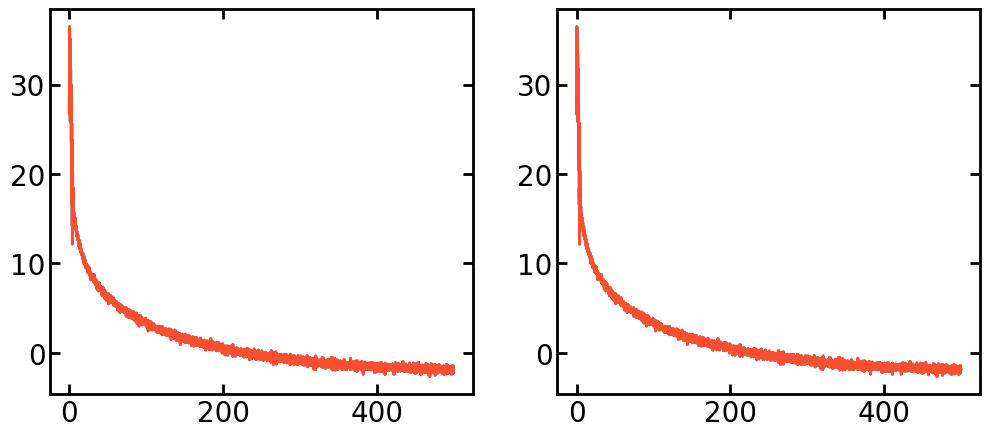

In [37]:
if lowpass_filter is not None:
    order = 25
    for i in range(signal_wake.shape[1]):
        signal_wake[:, i] = butter_lowpass_filter(signal_wake[:, i], lowpass_filter, 1/dt if mode =='lfp' else 1/dt_rate, order=order)
        signal_anesthesia[:, i] = butter_lowpass_filter(signal_anesthesia[:, i], lowpass_filter, 1/dt if mode =='lfp' else 1/dt_rate, order=order)

fft_a_orig = np.fft.rfft(signal_anesthesia_orig.T).T
fft_a = np.fft.rfft(signal_anesthesia.T).T
fft_w_orig = np.fft.rfft(signal_wake_orig.T).T
fft_w = np.fft.rfft(signal_wake.T).T
freq = np.fft.rfftfreq(signal_anesthesia_orig.shape[0], dt if mode == 'lfp' else dt_rate)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(freq[1:], 10*np.log10(np.abs(fft_w_orig[1:, 0])))
plt.plot(freq[1:], 10*np.log10(np.abs(fft_w[1:, 0])))
plt.subplot(1, 2, 2)
plt.plot(freq[1:], 10*np.log10(np.abs(fft_w_orig[1:, 0])))
plt.plot(freq[1:], 10*np.log10(np.abs(fft_w[1:, 0])))

plt.show()

In [38]:
n_components = 3
if shared_basis:
    me_w = manifold_embed(n_components)
    me_w.fit(np.vstack([signal_wake, signal_anesthesia]))
    signal_wake_me = me_w.transform(signal_wake).cpu()
    signal_anesthesia_me = me_w.transform(signal_anesthesia).cpu()
    me_a = me_w
else:
        
    me_w = manifold_embed(n_components)
    signal_wake_me = me_w.fit_transform(signal_wake).cpu()
    
    me_a = manifold_embed(n_components)
    signal_anesthesia_me = me_a.fit_transform(signal_anesthesia).cpu()

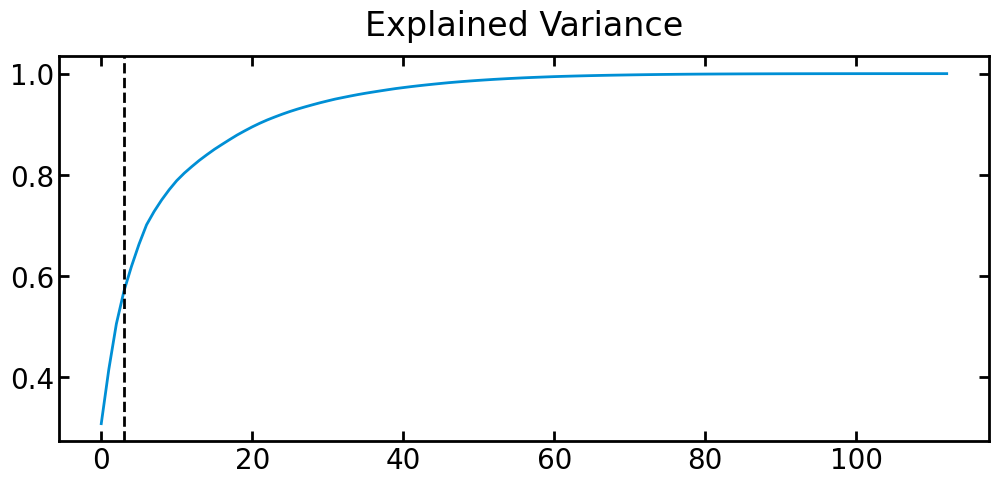

In [39]:
if embed_type == 'PCA':
    if shared_basis:
        fig, axs = plt.subplots(1, 1, figsize=(12, 5), sharex=True, sharey=True)

        ax = axs
        cumulative_exp_var_wake = (torch.cumsum(me_w.S**2, 0)/((me_w.S**2).sum())).cpu()
        ax.plot(cumulative_exp_var_wake)
        ax.axvline(me_w.n_components, linestyle='--', c='k')
        ax.set_title('Explained Variance')

    else:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

        ax = axs[0]
        cumulative_exp_var_wake = (torch.cumsum(pca_w.S**2, 0)/((pca_w.S**2).sum())).cpu()
        ax.plot(cumulative_exp_var_wake)
        ax.axvline(pca_w.n_components, linestyle='--', c='k')
        ax.set_title('Wakeful Explained Variance')

        ax = axs[1]
        cumulative_exp_var_anesthesia = (torch.cumsum(pca_a.S**2, 0)/((pca_a.S**2).sum())).cpu()
        ax.plot(cumulative_exp_var_anesthesia)
        ax.axvline(pca_a.n_components, linestyle='--', c='k')
        ax.set_title('Anesthetic Explained Variance')

        plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

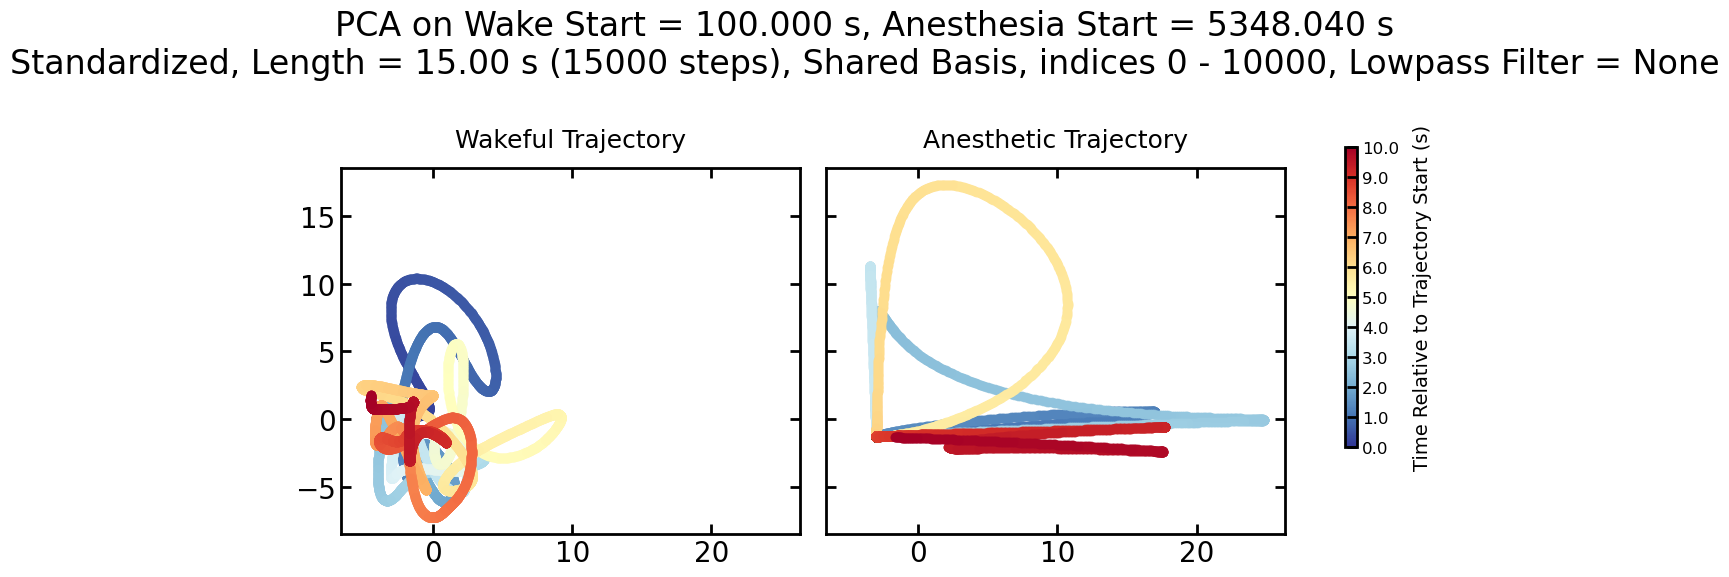

In [40]:
%matplotlib inline
three_dim = False
trial_nums = [0]
density_plot = False
scatter = True
start_ind = 0
# end_ind = window_lfp if mode == 'lfp' else window_rate
end_ind = 10000
cbar_step = 1000
norm = colors.Normalize(vmin=start_ind, vmax=end_ind)
cmap = plt.cm.get_cmap('RdYlBu_r')

if three_dim:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(projection="3d"))
else:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

if scatter:
    plot_funcs = [axs[0].scatter, axs[1].scatter]
else:
    plot_funcs = [axs[0].plot, axs[1].plot]
    

if density_plot:
    c = 'k'
    alpha = 0.1
    if not three_dim:
        plot_funcs[0](signal_wake_me[start_ind:end_ind, 0], signal_wake_me[start_ind:end_ind, 1], color=c, alpha=alpha)
        plot_funcs[1](signal_anesthesia_me[start_ind:end_ind, 0], signal_anesthesia_me[start_ind:end_ind, 1], color=c, alpha=alpha)
    else:
        plot_funcs[0](signal_wake_me[start_ind:end_ind, 0], signal_wake_me[start_ind:end_ind, 1], signal_wake_me[start_ind:end_ind, 2], color=c, alpha=alpha)
        plot_funcs[1](signal_anesthesia_me[start_ind:end_ind, 0], signal_anesthesia_me[start_ind:end_ind, 1], signal_anesthesia_me[start_ind:end_ind, 2], color=c, alpha=alpha)
else:
    for i in tqdm(range(start_ind, end_ind, 2)):
        c = cmap(norm(i))
        alpha=0.8
        if not three_dim:
            plot_funcs[0](signal_wake_me[i:i+2, 0], signal_wake_me[i:i+2, 1], color=c, alpha=alpha)
            plot_funcs[1](signal_anesthesia_me[i:i+2, 0], signal_anesthesia_me[i:i+2, 1], color=c, alpha=alpha)
        else:
            plot_funcs[0](signal_wake_me[i:i+2, 0], signal_wake_me[i:i+2, 1], signal_wake_me[i:i+2, 2], color=c, alpha=alpha)
            plot_funcs[1](signal_anesthesia_me[i:i+2, 0], signal_anesthesia_me[i:i+2, 1], signal_anesthesia_me[i:i+2, 2], color=c, alpha=alpha)
axs[0].set_title(f'Wakeful Trajectory', fontsize=18)
axs[1].set_title(f'Anesthetic Trajectory', fontsize=18)
# if three_dim:
#     set_axes_equal(axs[0])
#     set_axes_equal(axs[1])

# fig.suptitle(f"Isomap on {num_trajs} Trajector{'ies' if num_trajs > 1 else 'y'} from {area} with {n_neighbors} Neighbors and Delay Lag p={p}, PCA dim = {n_pca_components}, Subsample = {subsample}", fontsize=19)
# fig.suptitle(f"Isomap on Continuous Trajector{'ies' if num_trajs > 1 else 'y'} from {area} with {n_neighbors} Neighbors and Delay Lag p={p}, PCA dim = {n_pca_components}, Subsample = {subsample}", fontsize=19)
fig.suptitle(f"{embed_type} on Wake Start = {start_wake:.3f} s, Anesthesia Start = {start_anesthesia:.3f} s\n{'Not ' if not standardize else ''}Standardized, Length = {(window_lfp*dt if mode == 'lfp' else (window_rate*dt_rate)):.2f} s ({window_lfp if mode == 'lfp' else window_rate} steps), {'Shared' if shared_basis else 'Split'} Basis, indices {start_ind} - {end_ind}, Lowpass Filter = {lowpass_filter}")
plt.tight_layout()

if not density_plot:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.25, 0.01, 0.5])
    # cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, leadup + post, 250), label='Time Relative to Tone (ms)')
    # cbar.ax.set_yticklabels(np.arange(-leadup, post, 250), fontsize=12)

    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(start_ind, end_ind + 1, cbar_step), label='Time Relative to Tone (ms)')
    cbar.ax.set_yticklabels(np.arange(start_ind, end_ind + 1, cbar_step)*dt_rate, fontsize=12)
    cbar.set_label(label=f'Time Relative to Trajectory Start (s)', fontsize=14)

plt.show()